<a href="https://colab.research.google.com/github/whyu38/analisis-sentimen-project/blob/main/Analisis_Sentimen_Aplikasi_Wahyu_Sukma_J.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Data Loading

In [ ]:
# Load data
df = pd.read_csv('hasil_scraping.csv')
df.head()

,content,score
0,"ini kalo di gojek notip nya suka telat, tolong...",3
1,"pesan gofood, bahan baku resto ga ada. resto d...",1
2,saat ini saya mendapatkan pelayanan yang sanga...,1
3,aplikasi ini sangat berguna,5
4,agak sedeng app gojek. gw pk app ni dah dr lam...,1


# Data Preprocessing & Labeling

In [ ]:
# 1. Pastikan Label menjadi 3 Kelas
def labeling(score):
    if score < 3:
        return 'Negatif'
    elif score == 3:
        return 'Netral'
    else:
        return 'Positif'

df['sentiment'] = df['score'].apply(labeling)

# 2. Cleaning Text Sederhana
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.strip()
    return text

df['clean_text'] = df['content'].apply(clean_text)

# 3. Cek Distribusi Kelas (Penting untuk Laporan)
print(df['sentiment'].value_counts())

le = LabelEncoder()
y = le.fit_transform(df['sentiment'])
y = to_categorical(y)

sentiment
Positif    7625
Negatif    3922
Netral      453
Name: count, dtype: int64


# Data Splitting & Tokenization

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], y, test_size=0.2, random_state=42
)

# Tokenizer
vocab_size = 5000
oov_tok = "<OOV>"
max_length = 100
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Konversi ke Sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Shape Training:", X_train_pad.shape)
print("Shape Testing:", X_test_pad.shape)

Shape Training: (9600, 100)
Shape Testing: (2400, 100)


# Callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
            print("\nAkurasi pada training set dan validation set telah mencapai >92%!")
            self.model.stop_training = True

callbacks = myCallback()

# Model Training

In [ ]:
def create_model(schema):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))

    if schema == 'LSTM':
        # Skema 1: LSTM
        model.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    elif schema == 'GRU':
        # Skema 2: GRU (Gated Recurrent Unit) - Variasi Algoritma
        model.add(tf.keras.layers.GRU(64, dropout=0.2))
    elif schema == 'Bidirectional':
        # Skema 3: Bidirectional LSTM - Variasi Arsitektur
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# List eksperimen
schemas = ['LSTM', 'GRU', 'Bidirectional']
history_dict = {}

for schema in schemas:
    print(f"\nTraining Model dengan Skema: {schema} ===================")
    model = create_model(schema)
    hist = model.fit(
        X_train_pad, y_train,
        epochs=15,
        validation_data=(X_test_pad, y_test),
        callbacks=[callbacks],
        verbose=1,
        batch_size=128
    )
    history_dict[schema] = hist
    final_model = model


Training Model dengan Skema: LSTM ===================
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.6371 - loss: 0.8421 - val_accuracy: 0.6342 - val_loss: 0.7786
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.6424 - loss: 0.7791 - val_accuracy: 0.6342 - val_loss: 0.7787
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.6343 - loss: 0.7819 - val_accuracy: 0.6342 - val_loss: 0.7787
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6406 - loss: 0.7757 - val_accuracy: 0.6342 - val_loss: 0.7817
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.6433 - loss: 0.7719 - val_accuracy: 0.6342 - val_loss: 0.7792
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.6391 - loss: 0.7782 - val_accuracy: 0.6342 - val_loss: 0.7791
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.6354 - loss: 0.7866 - val_accuracy: 0.6342 - val_loss: 0.7804
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.6367 - loss: 0.7781 - val_accuracy: 0.634

# Model Evaluation

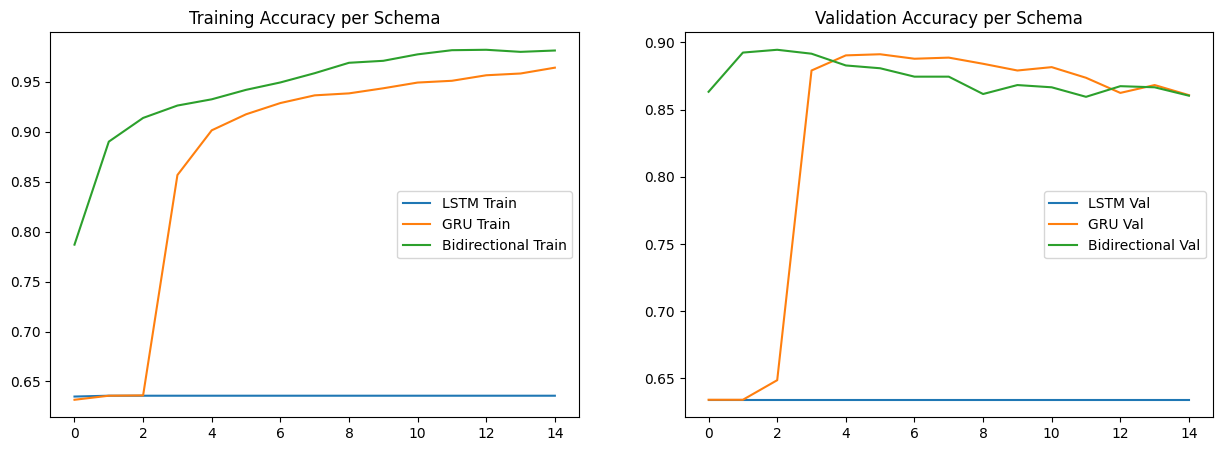

In [ ]:
plt.figure(figsize=(15, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
for schema in schemas:
    acc = history_dict[schema].history['accuracy']
    plt.plot(acc, label=f'{schema} Train')
plt.title('Training Accuracy per Schema')
plt.legend()

# Plot Validasi Akurasi
plt.subplot(1, 2, 2)
for schema in schemas:
    val_acc = history_dict[schema].history['val_accuracy']
    plt.plot(val_acc, label=f'{schema} Val')
plt.title('Validation Accuracy per Schema')
plt.legend()
plt.show()

# Inference

In [ ]:
print("\n=== PENGUJIAN MODEL (INFERENCE) ===")

input_text = [
    "Aplikasi ini sangat bermanfaat, fiturnya lengkap dan mudah dipakai",
    "Sering crash saat dibuka, sangat mengecewakan tolong diperbaiki",
    "Aplikasinya lumayan, tapi kadang agak lambat loadingnya"
]

# Preprocessing input manual
seq = tokenizer.texts_to_sequences(input_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Prediksi
predictions = final_model.predict(padded)
labels = ['Negatif', 'Netral', 'Positif']

for i, text in enumerate(input_text):
    class_idx = np.argmax(predictions[i])
    print(f"\nTeks: {text}")
    print(f"Prediksi: {labels[class_idx]} (Confidence: {predictions[i][class_idx]:.2f})")


=== PENGUJIAN MODEL (INFERENCE) ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

Teks: Aplikasi ini sangat bermanfaat, fiturnya lengkap dan mudah dipakai
Prediksi: Positif (Confidence: 1.00)

Teks: Sering crash saat dibuka, sangat mengecewakan tolong diperbaiki
Prediksi: Positif (Confidence: 0.89)

Teks: Aplikasinya lumayan, tapi kadang agak lambat loadingnya
Prediksi: Positif (Confidence: 0.97)
